In [74]:
import torch
import pandas as pd
import esm
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, mean_squared_error
from Bio import SeqIO
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
EMB_PATH_PU = "./embeddings/pu"
EMB_PATH_NONPU = "./embeddings/nonpu"
EMB_UNKOWN = "./embeddings/unknown"

In [3]:
#Create folders for embeddings if they don't exist
os.makedirs(EMB_PATH_PU, exist_ok=True)
os.makedirs(EMB_PATH_NONPU, exist_ok=True)
os.makedirs(EMB_UNKOWN, exist_ok=True)

# Data Load


Open Non Core Pu file


In [4]:
with open("SET_PUs_NON_CORES (1).txt") as f:
    No_Pu = f.readlines()

for i in range(len(No_Pu)):
    No_Pu[i] = No_Pu[i].strip()

Open Fasta data


In [5]:
fasta_file = "DB_PU_NONPU_SEQ.fasta"
fasta_sequence = []
with open(fasta_file, "r") as f:
    for record in SeqIO.parse(f, "fasta"):
        fasta_sequence.append(record)

Open Pu File


In [6]:
Pu = pd.read_table(
    "LISTS_CATFS_PU_PROTOTYPE_with_fused_famillies (1)", sep="\t", header=None
)

In [7]:
data = []
for line in Pu[0]:
    liste = []

    line = line.split(" ")
    for element in line:
        if element != "":
            liste.append(element)
    data.append(liste)

In [8]:
CLASS = []
ARCHITECTURE = []
TOPOLOGY = []
NANOFOLD = []
FREQUENCY = []
PROTO_FOLD_PROTOTYPE = []
PU_FAMILY_MEMBERS_CATEGORY = []
for element in data[7:]:
    CLASS.append(element[0])
    ARCHITECTURE.append(element[1])
    TOPOLOGY.append(element[2])
    NANOFOLD.append(element[3])
    FREQUENCY.append(element[4])
    PROTO_FOLD_PROTOTYPE.append(element[5])
    PU_FAMILY_MEMBERS_CATEGORY.append(element[6:])

In [9]:
for i in range(len(PU_FAMILY_MEMBERS_CATEGORY)):
    PU_FAMILY_MEMBERS_CATEGORY[i][0] = PU_FAMILY_MEMBERS_CATEGORY[i][0].split(":")[1]

In [10]:
d = {
    "CLASS": CLASS,
    "ARCHITECTURE": ARCHITECTURE,
    "TOPOLOGY": TOPOLOGY,
    "NANOFOLD": NANOFOLD,
    "FREQUENCY": FREQUENCY,
    "PROTO_FOLD_PROTOTYPE": PROTO_FOLD_PROTOTYPE,
    "PU_FAMILY_MEMBERS_CATEGORY": PU_FAMILY_MEMBERS_CATEGORY,
}

In [11]:
Pu_families = pd.DataFrame(data=d)

In [12]:
Pu_families.head()

,CLASS,ARCHITECTURE,TOPOLOGY,NANOFOLD,FREQUENCY,PROTO_FOLD_PROTOTYPE,PU_FAMILY_MEMBERS_CATEGORY
0,Alpha-beta,bab,bUaUb,35.g306,9,1MJNA_2_127_163,"[1U14A_2_1_37, 2WW8A_12_487_525, 2DZXA_4_82_11..."
1,All-alpha,a,a,30.g147,91,2EO5A_10_78_103,"[2EO5A_10_78_103, 3QVQA_7_118_144, 3V7NA_14_35..."
2,All-alpha,a,a,20.g594,5,1YBTA_1_16_34,"[3JSZA_14_357_376, 3A24A_10_525_542, 1YBTA_1_1..."
3,Alpha-beta,aba,aUbLa,35.g162,157,1YISA_10_258_288,"[3K7XA_10_267_294, 4G10A_4_105_133, 3C3RA_10_2..."
4,Alpha-beta,baba,bUaUbLa,45.g94,31,3ICSA_11_510_555,"[2HHGA_2_86_132, 3SNKA_1_1_48, 2UUUA_6_300_347..."


Set data labels


In [13]:
Sequence = []
Is_pu = []
file = []
for record in fasta_sequence:
    Sequence.append(str(record.seq))
    file_name = f'{record.id}_{record.description.split("|")[1].split(" ")[1].split(":")[1]}_{record.description.split("|")[2].split(" ")[1].split(":")[1]}_{record.description.split("|")[3].split(" ")[1].split(":")[1]}'
    file.append(file_name)
    if file_name in No_Pu:
        Is_pu.append(0)
    elif file_name in Pu_families["PROTO_FOLD_PROTOTYPE"].values:
        Is_pu.append(1)
    else:
        Is_pu.append(2)

In [14]:
d = {"Sequence": Sequence, "Is_pu": Is_pu, "file": file}

In [15]:
seq_data = pd.DataFrame(data=d)

In [16]:
seq_data.head()

,Sequence,Is_pu,file
0,DGERQFSTLKSTVEAIWAG,2,12ASA_10_122_140
1,AYIAKQRQISFVKSHFSRQLEERL,2,12ASA_10_1_24
2,IKATEAAVSEEFGLAP,2,12ASA_10_141_156
3,FLPDQIHFVHSQELLSRYPDLDAKGRERAIAKDLGAVFLV,2,12ASA_10_157_196
4,GIGGKLSDGHRHDVRA,2,12ASA_10_197_212


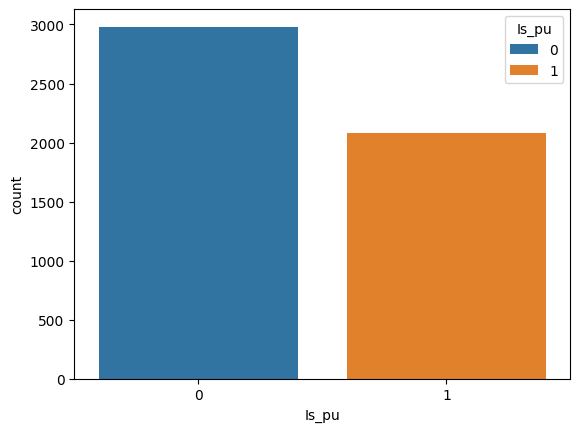

In [17]:
# Count on pu and non pu


sns.countplot(x="Is_pu", data=seq_data.loc[(seq_data["Is_pu"] != 2)], hue="Is_pu")
plt.show()

In [18]:
# count is_pu=2 and plot value using pandas
print(
    "unkown %d\npu %d\nnon-pu %d"
    % (
        seq_data.loc[(seq_data["Is_pu"] == 2)]["Is_pu"].count(),
        seq_data.loc[(seq_data["Is_pu"] == 1)]["Is_pu"].count(),
        seq_data.loc[(seq_data["Is_pu"] == 0)]["Is_pu"].count(),
    )
)

unkown 1051653
pu 2081
non-pu 2981


# Embedding


Data for embedding


In [19]:
pre_emb_pu = seq_data.loc[(seq_data["Is_pu"] == 1)][["Sequence", "file"]]
pre_emb_nonpu = seq_data.loc[(seq_data["Is_pu"] == 0)][["Sequence", "file"]]

Transformers


In [20]:
def embedding_preparation(pre_emb, EMB_PATH):
    model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()

    batch_converter = alphabet.get_batch_converter()

    model.eval()  # disables dropout for deterministic results

    for line in pre_emb.values:
        # Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)

        data = [(line[1], line[0])]

        batch_labels, batch_strs, batch_tokens = batch_converter(data)

        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

        # Extract per-residue representations (on CPU)

        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[33], return_contacts=True)

            torch.save(results, f"{EMB_PATH}/{line[1]}.pt")

In [37]:
embedding_preparation(pre_emb_pu, EMB_PATH_PU)
embedding_preparation(pre_emb_nonpu, EMB_PATH_NONPU)

# Dataset preparation


In [21]:
def padding(tensor, max_size):
    if tensor.numpy().shape[0] < max_size:
        padding = max_size - tensor.numpy().shape[0]
        tensor = tf.pad(tensor, ((0, padding), (0, 0)))
    return tensor

In [22]:
# List of all embeddings
def get_embedding_list(PATH, label, max_size):
    list_of_embeddings = []
    for filename in os.listdir(PATH):
        embedding_dict = torch.load(os.path.join(PATH, filename))["representations"][
            33
        ][0]

        embedding_tensor = tf.convert_to_tensor(embedding_dict)
        embedding_tensor = padding(embedding_tensor, max_size)
        list_of_embeddings.append(embedding_tensor)
    return list_of_embeddings, [label] * len(list_of_embeddings)

In [23]:
batch_size = 150

In [24]:
pd_non_pu, label_non_pu = get_embedding_list(EMB_PATH_NONPU, 0, 62)
pd_pu, label_pu = get_embedding_list(EMB_PATH_PU, 1, 62)

In [25]:
embeddings = pd_non_pu + pd_pu
labels = label_non_pu + label_pu

In [26]:
print(embeddings[0])

tf.Tensor(
[[ 0.04803988  0.03526633 -0.01760992 ... -0.3153562   0.2511406
  -0.13878508]
 [-0.0099561   0.02071003  0.23420365 ...  0.29207087 -0.13407305
  -0.05613112]
 [-0.01918759  0.02974552  0.10829733 ...  0.11340906 -0.06686007
   0.13081023]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]], shape=(62, 1280), dtype=float32)


In [27]:
print(labels[0])

0


In [79]:
# Split data into train and validation
from sklearn.model_selection import train_test_split

train_test_set, val_set, train_test_labels, val_labels = train_test_split(
    embeddings, labels, test_size=0.1,random_state=31,stratify=labels
)
train_set, test_set, train_labels, test_labels = train_test_split(
    train_test_set, train_test_labels, test_size=0.2,random_state=31,stratify=train_test_labels
)

In [29]:
def conv_data(data, labels):
    return tf.data.Dataset.from_tensor_slices((data, labels))

In [30]:
def prep_data(train, lab, batch_size):
    tf_dataset = conv_data(train, lab)
    tf_dataset = tf_dataset.batch(batch_size)
    tf_dataset = tf_dataset.prefetch(tf.data.AUTOTUNE)
    return tf_dataset

In [80]:
tf_dataset = prep_data(train_set, train_labels, batch_size)
tf_val_dataset = prep_data(val_set, val_labels, batch_size)
tf_test_dataset = prep_data(test_set, test_labels, batch_size)

# Tensorflow model:

Protein classification


In [110]:
# Compute class weights


class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(train_labels), y=train_labels
)
class_weights = dict(enumerate(class_weights))

In [111]:
model_tf = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(62, 1280)),
        tf.keras.layers.GRU(50, return_sequences=True, dropout=0.3),
        tf.keras.layers.GRU(20, return_sequences=True,dropout=0.1),
        tf.keras.layers.GRU(10, dropout=0.2),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_tf.summary()
model_tf.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_30 (GRU)                (None, 62, 50)            199800    
                                                                 
 gru_31 (GRU)                (None, 62, 20)            4320      
                                                                 
 gru_32 (GRU)                (None, 10)                960       
                                                                 
 dense_16 (Dense)            (None, 2)                 22        
                                                                 
Total params: 205102 (801.18 KB)
Trainable params: 205102 (801.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [112]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

model_tf.fit(
    tf_dataset,
    epochs=500,
    validation_data=tf_test_dataset,
    callbacks=callback,
    class_weight=class_weights,
    batch_size=batch_size,
)

Epoch 1/500
25/25 [==============================] - 5s 136ms/step - loss: 0.6932 - accuracy: 0.5556 - val_loss: 0.6893 - val_accuracy: 0.5871
Epoch 2/500
25/25 [==============================] - 3s 111ms/step - loss: 0.6897 - accuracy: 0.5964 - val_loss: 0.6870 - val_accuracy: 0.4688
Epoch 3/500
25/25 [==============================] - 3s 114ms/step - loss: 0.6872 - accuracy: 0.4756 - val_loss: 0.6844 - val_accuracy: 0.4688
Epoch 4/500
25/25 [==============================] - 3s 114ms/step - loss: 0.6839 - accuracy: 0.4756 - val_loss: 0.6803 - val_accuracy: 0.4754
Epoch 5/500
25/25 [==============================] - 3s 119ms/step - loss: 0.6799 - accuracy: 0.4800 - val_loss: 0.6759 - val_accuracy: 0.4852
Epoch 6/500
25/25 [==============================] - 3s 118ms/step - loss: 0.6752 - accuracy: 0.4959 - val_loss: 0.6720 - val_accuracy: 0.5038
Epoch 7/500
25/25 [==============================] - 3s 118ms/step - loss: 0.6706 - accuracy: 0.5038 - val_loss: 0.6681 - val_accuracy: 0.5279

In [113]:
def plot_history(history, metric):
    plt.plot(history.history[f"{metric}"])
    plt.plot(history.history[f"val_{metric}"])
    plt.title(f"model {metric}")
    plt.legend(["train", "test"], loc="upper left")
    plt.ylabel(f"{metric}")
    plt.xlabel("epoch")
    plt.show()

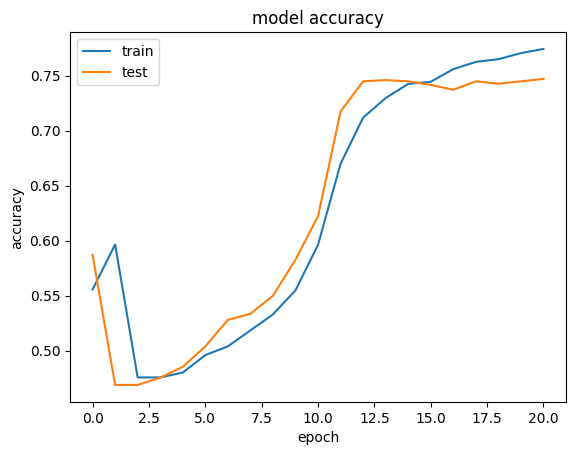

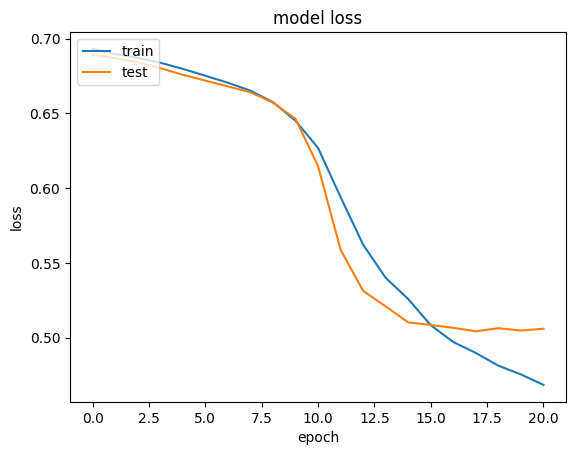

In [114]:
plot_history(model_tf.history, "accuracy")
plot_history(model_tf.history, "loss")

4/4 [==============================] - 1s 29ms/step


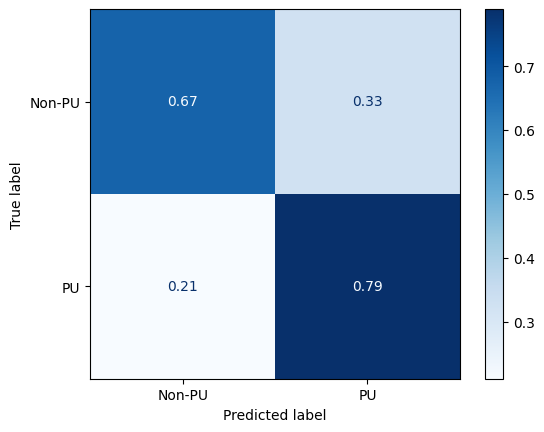

In [115]:
ConfusionMatrixDisplay.from_predictions(
    val_labels,
    model_tf.predict(tf_val_dataset).argmax(axis=1),
    cmap="Blues",
    normalize="true",
    display_labels=["Non-PU", "PU"],
)
plt.show()

In [116]:
# Compute balanced accuracy

print(
    "Balanced accuracy: %0.2f"
    % balanced_accuracy_score(
        val_labels, model_tf.predict(tf_val_dataset).argmax(axis=1)
    ),
)

#Compute MSE

print(
    "MSE: %0.2f" 
    % mean_squared_error(
        val_labels, model_tf.predict(tf_val_dataset).argmax(axis=1)
        )
    )

4/4 [==============================] - 0s 26ms/step
Balanced accuracy: 0.73
4/4 [==============================] - 0s 23ms/step
MSE: 0.28


In [117]:
def map_labels(labels):
    liste = []
    mapped = {0: "Non-PU", 1: "PU"}
    for element in labels:
      liste.append(mapped[element])
    return liste

4/4 [==============================] - 0s 23ms/step


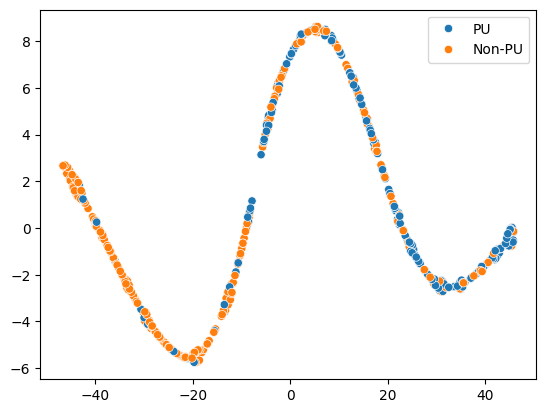

In [118]:
best_red_tsne = TSNE(n_components=2, learning_rate="auto", init="pca",random_state=42).fit_transform(
    model_tf.predict(tf_val_dataset)
)
sns.scatterplot(x=best_red_tsne[:,0],y=best_red_tsne[:,1],hue=map_labels(val_labels))
plt.show()

Fine tune model


In [119]:
# fine tune model_tf

Xtune,Xtest_tune,Ytune,Ytest_tune = train_test_split(
    val_set, val_labels, test_size=0.1, random_state=42,stratify=val_labels)

In [120]:
class_weights_tune = compute_class_weight(
    class_weight="balanced", classes=np.unique(Ytune), y=Ytune
)
class_weights_tune = dict(enumerate(class_weights_tune))

In [121]:
model_tf.fit(
    prep_data(Xtune, Ytune, batch_size),
    epochs=500,
    validation_data=prep_data(Xtest_tune, Ytest_tune, batch_size),
    callbacks=callback,
    class_weight=class_weights_tune,
    batch_size=batch_size,
)

Epoch 1/500
4/4 [==============================] - 0s 86ms/step - loss: 0.5848 - accuracy: 0.6952 - val_loss: 0.4063 - val_accuracy: 0.8235
Epoch 2/500
4/4 [==============================] - 0s 99ms/step - loss: 0.5778 - accuracy: 0.7259 - val_loss: 0.4001 - val_accuracy: 0.8235
Epoch 3/500
4/4 [==============================] - 0s 92ms/step - loss: 0.5635 - accuracy: 0.7215 - val_loss: 0.3940 - val_accuracy: 0.8627
Epoch 4/500
4/4 [==============================] - 0s 90ms/step - loss: 0.5542 - accuracy: 0.7193 - val_loss: 0.4044 - val_accuracy: 0.8235
Epoch 5/500
4/4 [==============================] - 0s 94ms/step - loss: 0.5266 - accuracy: 0.7259 - val_loss: 0.3802 - val_accuracy: 0.8431
Epoch 6/500
4/4 [==============================] - 0s 102ms/step - loss: 0.5292 - accuracy: 0.7478 - val_loss: 0.3667 - val_accuracy: 0.8431
Epoch 7/500
4/4 [==============================] - 0s 91ms/step - loss: 0.5300 - accuracy: 0.7412 - val_loss: 0.3906 - val_accuracy: 0.8235
Epoch 8/500
4/4 [==

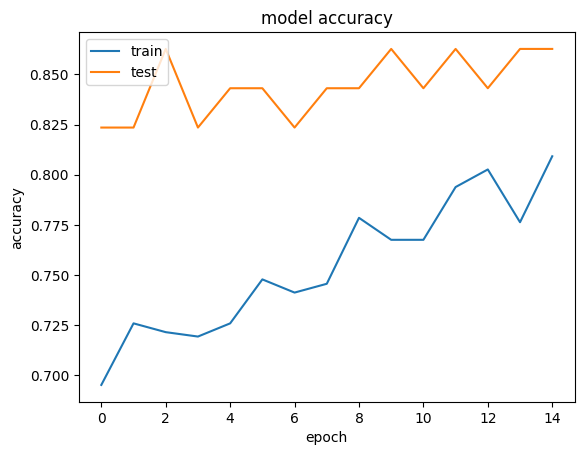

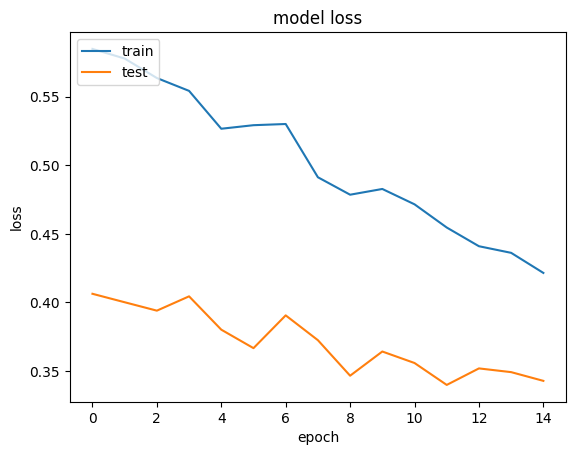

1/1 [==============================] - 0s 22ms/step


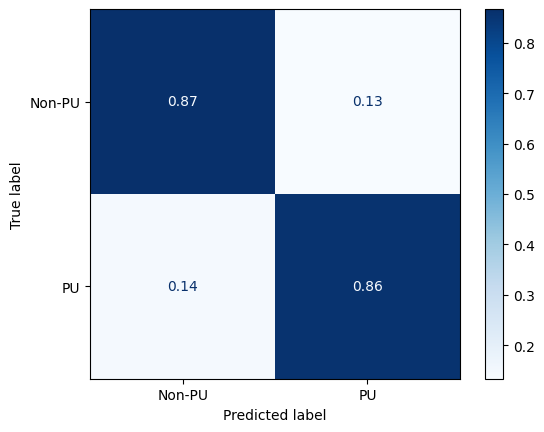

1/1 [==============================] - 0s 37ms/step
Balanced accuracy: 0.86
1/1 [==============================] - 0s 23ms/step
MSE: 0.14


In [122]:
plot_history(model_tf.history, "accuracy")
plot_history(model_tf.history, "loss")
ConfusionMatrixDisplay.from_predictions(
    Ytest_tune,
    model_tf.predict(prep_data(Xtest_tune, Ytest_tune, batch_size)).argmax(axis=1),
    cmap="Blues",
    normalize="true",
    display_labels=["Non-PU", "PU"],
)
plt.show()

print(
    "Balanced accuracy: %0.2f"
    % balanced_accuracy_score(
        Ytest_tune, model_tf.predict(prep_data(Xtest_tune, Ytest_tune, batch_size)).argmax(axis=1)
    ),
)

print(
    "MSE: %0.2f" 
    % mean_squared_error(
        Ytest_tune, model_tf.predict(prep_data(Xtest_tune, Ytest_tune, batch_size)).argmax(axis=1)
        )
    )

4/4 [==============================] - 0s 27ms/step


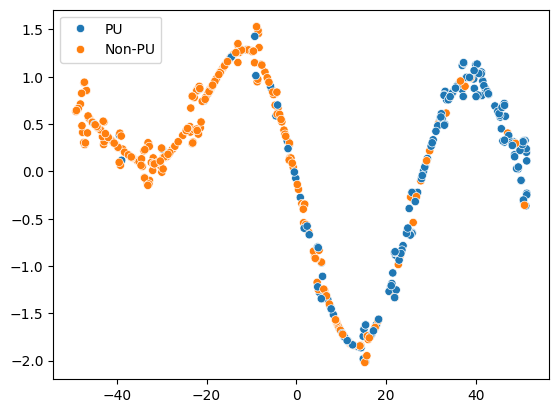

In [125]:
tuned_tsne = TSNE(n_components=2, learning_rate="auto", init="pca",random_state=42).fit_transform(
    model_tf.predict(tf_val_dataset)
)
sns.scatterplot(x=tuned_tsne[:,0],y=tuned_tsne[:,1],hue=map_labels(val_labels))
plt.show()

Application


In [126]:
def is_pu_from_file(PATH, filename):
    embedding_dict = torch.load(os.path.join(PATH, filename))["representations"][33][0]

    embedding_tensor = tf.convert_to_tensor(embedding_dict)
    embedding_tensor = padding(embedding_tensor, 62)
    res = model_tf.predict(embedding_tensor[None,]).argmax(axis=1)[0]
    print("PU\npred = ", res) if res == 1 else print("Non-PU\npred = ", res)

In [127]:
def is_pu_from_seq(seq, name):
    model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()

    batch_converter = alphabet.get_batch_converter()

    model.eval()  # disables dropout for deterministic results

    # Prepare data
    data = [(name, seq)]

    batch_labels, batch_strs, batch_tokens = batch_converter(data)

    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    # Extract per-residue representations (on CPU)

    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    embedding_dict = results["representations"][33][0]

    embedding_tensor = tf.convert_to_tensor(embedding_dict)
    embedding_tensor = padding(embedding_tensor, 62)
    res = model_tf.predict(embedding_tensor[None,]).argmax(axis=1)[0]
    print("PU\npred = ", res) if res == 1 else print("Non-PU\npred = ", res)

In [128]:
is_pu_from_file(EMB_PATH_PU, "1A0CA_12_310_329.pt")

1/1 [==============================] - 0s 493ms/step
PU
pred =  1


In [129]:
is_pu_from_file(EMB_PATH_NONPU, "1A0TP_10_23_44.pt")

1/1 [==============================] - 0s 16ms/step
Non-PU
pred =  0


In [45]:
seq_data.loc[(seq_data["file"] == "12ASA_10_213_228")]

,Sequence,Is_pu,file
5,PDYDDWSTPSELGHAG,2,12ASA_10_213_228


In [130]:
is_pu_from_seq("PDYDDWSTPSELGHAG","12ASA_10_213_228")

1/1 [==============================] - 0s 61ms/step
Non-PU
pred =  0


Get last hidden layer of GRU


In [47]:
inputs= tf.keras.layers.Input(shape=(62, 1280))
GRU = tf.keras.layers.GRU(50, return_sequences=True,dropout=0.3)(inputs)
GRU2 = tf.keras.layers.GRU(20, return_sequences=True, dropout=0.1)(GRU)
GRU3,state_h = tf.keras.layers.GRU(10,return_state=True, dropout=0.2)(GRU2)
output = tf.keras.layers.Dense(2,activation = "softmax")(GRU3)
model_tf2 = tf.keras.Model(inputs=inputs, outputs=[output,state_h])
model_tf2.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_tf2.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 62, 1280)]        0         
                                                                 
 gru_3 (GRU)                 (None, 62, 50)            199800    
                                                                 
 gru_4 (GRU)                 (None, 62, 20)            4320      
                                                                 
 gru_5 (GRU)                 [(None, 10),              960       
                              (None, 10)]                        
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 205102 (801.18 KB)
Trainable params: 205102 (801.18 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [48]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

model_tf2.fit(
    tf_dataset,
    epochs=500,
    validation_data=tf_test_dataset,
    class_weight=class_weights,
    batch_size=batch_size,
    callbacks=callback,
)

Epoch 1/500
25/25 [==============================] - 6s 146ms/step - loss: 2.1674 - dense_1_loss: 0.6946 - gru_5_loss: 1.4729 - dense_1_accuracy: 0.4129 - gru_5_accuracy: 0.3970 - val_loss: 1.9365 - val_dense_1_loss: 0.6981 - val_gru_5_loss: 1.2384 - val_dense_1_accuracy: 0.4107 - val_gru_5_accuracy: 0.5827
Epoch 2/500
25/25 [==============================] - 3s 119ms/step - loss: 1.9062 - dense_1_loss: 0.6958 - gru_5_loss: 1.2104 - dense_1_accuracy: 0.4121 - gru_5_accuracy: 0.5466 - val_loss: 1.7997 - val_dense_1_loss: 0.7002 - val_gru_5_loss: 1.0995 - val_dense_1_accuracy: 0.4118 - val_gru_5_accuracy: 0.5882
Epoch 3/500
25/25 [==============================] - 3s 112ms/step - loss: 1.7749 - dense_1_loss: 0.6961 - gru_5_loss: 1.0788 - dense_1_accuracy: 0.4121 - gru_5_accuracy: 0.5803 - val_loss: 1.6811 - val_dense_1_loss: 0.7010 - val_gru_5_loss: 0.9801 - val_dense_1_accuracy: 0.4118 - val_gru_5_accuracy: 0.5882
Epoch 4/500
25/25 [==============================] - 3s 114ms/step - loss

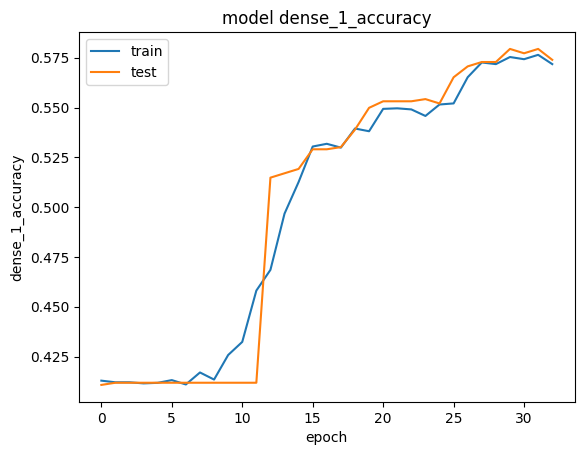

In [50]:
plot_history(model_tf2.history, "dense_1_accuracy")


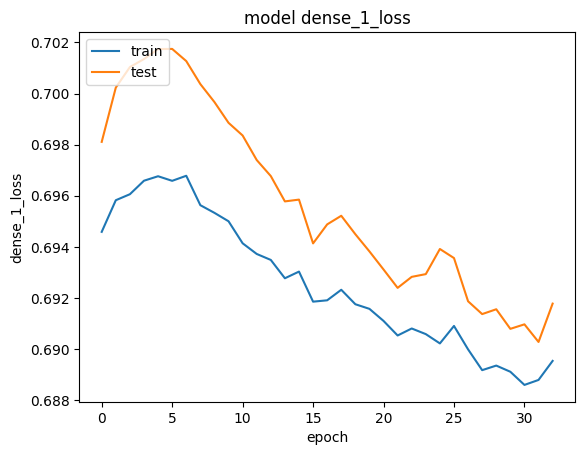

In [53]:

plot_history(model_tf2.history, "dense_1_loss")

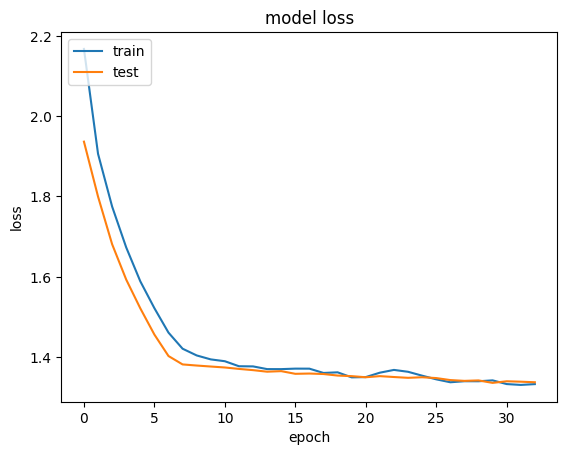

In [52]:
plot_history(model_tf2.history, "loss")

4/4 [==============================] - 0s 23ms/step


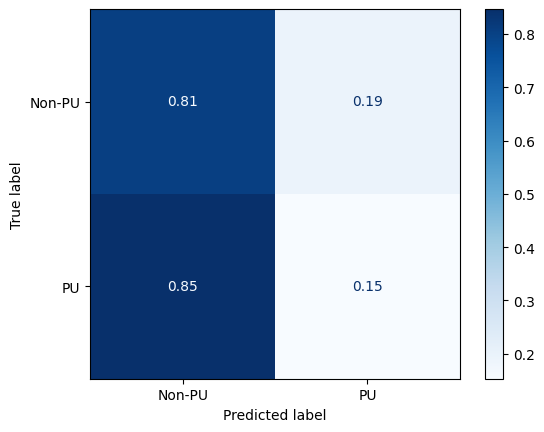

In [54]:
ConfusionMatrixDisplay.from_predictions(
    val_labels,
    model_tf2.predict(tf_val_dataset)[0].argmax(axis=1),
    cmap="Blues",
    normalize="true",
    display_labels=["Non-PU", "PU"],
)
plt.show()

In [55]:
# dimensional reduction on modeltf2 prediction using TSNE


red_tsne= TSNE(n_components=2,learning_rate="auto",random_state=42).fit_transform(model_tf2.predict(tf_val_dataset)[1])


4/4 [==============================] - 0s 23ms/step


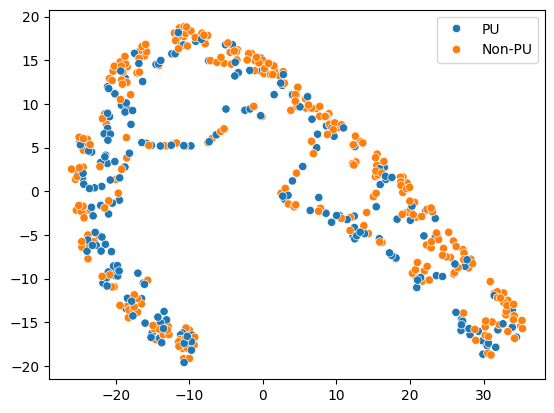

In [56]:
sns.scatterplot(x=red_tsne[:,0],y=red_tsne[:,1],hue=map_labels(val_labels))
plt.show()

UNKNOWN


In [ ]:
unknown = seq_data.loc[(seq_data["Is_pu"] == 2)][["Sequence", "file"]]

In [ ]:
embedding_preparation(unknown, EMB_UNKOWN)

In [70]:
is_pu_from_file(EMB_UNKOWN, "1A0CA_1_1_385.pt")

1/1 [==============================] - 0s 489ms/step
Non-PU
pred =  0


In [42]:
tensor_unknown = tf.convert_to_tensor(
    torch.load(EMB_UNKOWN + "/1A0CA_1_1_385.pt")["representations"][33][0]
)

In [43]:
set_unknown = tf.data.Dataset.from_tensor_slices(
    (tensor_unknown, [2] * len(tensor_unknown))
)
set_unknown = set_unknown.batch(128)
set_unknown = set_unknown.prefetch(tf.data.AUTOTUNE)

In [46]:
len(set_unknown)

4

famille PU MODEL


In [57]:
columns = [
    "CLASS",
    "ARCHITECTURE",
    "TOPOLOGY",
    "NANOFOLD",
    "PROTO_FOLD_PROTOTYPE",
]

In [58]:
data_category = Pu_families[columns]

In [59]:
def emb_missing():
    file_not_found = []
    seq_not_found = []
    
    
    for filename in data_category["PROTO_FOLD_PROTOTYPE"]:
        file_not_found.append(filename)
        seq_not_found.append(seq_data.loc[(seq_data["file"] == filename)]["Sequence"].values[0])
    embedding_preparation(pd.DataFrame({"Sequence": seq_not_found, "file": file_not_found}), EMB_PATH_PU)
    

In [60]:
def get_class_embdedding(max_size):
    list_of_embeddings = []
    for filename in data_category["PROTO_FOLD_PROTOTYPE"]:
        filename = filename + ".pt"

        embedding_dict = torch.load(os.path.join(EMB_PATH_PU, filename))["representations"][
            33
        ][0]
        embedding_tensor = tf.convert_to_tensor(embedding_dict)
        embedding_tensor = padding(embedding_tensor, max_size)
        list_of_embeddings.append(embedding_tensor.numpy())
    return list_of_embeddings

In [ ]:
emb_missing()

In [62]:
data_category["embeddings"]=get_class_embdedding(62)

/var/folders/8f/t8cnfn2s64bdpl_tr8rw788c0000gp/T/ipykernel_2574/1904032538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_category["embeddings"]=get_class_embdedding(62)


In [63]:
data_class=data_category[["ARCHITECTURE","TOPOLOGY","NANOFOLD","embeddings"]]

In [64]:
data_class

,ARCHITECTURE,TOPOLOGY,NANOFOLD,embeddings
0,bab,bUaUb,35.g306,"[[0.019140914, -0.0012203297, -0.003696097, 0...."
1,a,a,30.g147,"[[0.04035387, 0.004960995, -0.027747978, 0.037..."
2,a,a,20.g594,"[[0.051260896, 0.01472882, -0.08491606, 0.0148..."
3,aba,aUbLa,35.g162,"[[0.00392632, 0.0070587983, -0.013029493, 0.05..."
4,baba,bUaUbLa,45.g94,"[[0.13420565, 0.05972238, -0.011818785, -0.015..."
...,...,...,...,...
2856,aa,aLa,30.g286,"[[0.028978493, 0.020281252, -0.00629464, 0.037..."
2857,aba,aLbLa,30.g11,"[[0.044975597, 0.026170729, 0.032374, 0.034544..."
2858,bbba,bUbUbUa,55.g137,"[[0.09256006, 0.05710459, 0.00225823, -0.03073..."
2859,aa,aUa,35.g38,"[[-0.006201986, -0.0028695008, -0.06701272, -0..."


In [65]:
Xtrain_test,Xval,Ytrain_test,Yval = train_test_split(data_class.values,data_category["CLASS"],test_size=0.1,random_state=42)

In [66]:
Xtrain, xtest, Ytrain, ytest = train_test_split(
   Xtrain_test, Ytrain_test, test_size=0.2,random_state=42
)

In [613]:
Xtrain

array([['bba', 'bUbUa', '45.g103',
        array([[ 0.07044496,  0.02592208, -0.03962875, ..., -0.27855444,
                 0.16065443,  0.06287445],
               [ 0.08355206,  0.07412869, -0.11218919, ..., -0.07419663,
                 0.13451861, -0.076241  ],
               [ 0.24207282,  0.10000175, -0.05381908, ..., -0.08027937,
                 0.02477723,  0.003556  ],
               ...,
               [ 0.        ,  0.        ,  0.        , ...,  0.        ,
                 0.        ,  0.        ],
               [ 0.        ,  0.        ,  0.        , ...,  0.        ,
                 0.        ,  0.        ],
               [ 0.        ,  0.        ,  0.        , ...,  0.        ,
                 0.        ,  0.        ]], dtype=float32)              ],
       ['a', 'a', '20.g732',
        array([[ 0.00322035,  0.02259684, -0.03001918, ..., -0.27117938,
                 0.18581879, -0.0933952 ],
               [-0.10474979, -0.06090369, -0.05407615, ...,  0.09565611,

In [132]:

inputA= tf.keras.layers.Input(shape=(62, 1280))
GRU = tf.keras.layers.GRU(50, return_sequences=True,dropout=0.3)(inputA)
GRU2 = tf.keras.layers.GRU(20, return_sequences=True, dropout=0.1)(GRU)
GRU3 = tf.keras.layers.GRU(10, dropout=0.2)(GRU2)
output1 = tf.keras.layers.Dense(2,activation = "softmax")(GRU3)
x = tf.keras.Model(inputs=inputA, outputs=output1)
x.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 62, 1280)]        0         
                                                                 
 gru_37 (GRU)                (None, 62, 50)            199800    
                                                                 
 gru_38 (GRU)                (None, 62, 20)            4320      
                                                                 
 gru_39 (GRU)                (None, 10)                960       
                                                                 
 dense_22 (Dense)            (None, 2)                 22        
                                                                 
Total params: 205102 (801.18 KB)
Trainable params: 205102 (801.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [133]:
inputB = tf.keras.layers.Input(shape=3)
dense1 = tf.keras.layers.Dense(128, activation="relu")(inputB)
dense2 = tf.keras.layers.Dense(64, activation="relu")(dense1)
dense3 = tf.keras.layers.Dense(32, activation="relu")(dense2)
output2 = tf.keras.layers.Dense(2,activation = "softmax")(dense3)
y = tf.keras.Model(inputs=inputB, outputs=output2)
y.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_23 (Dense)            (None, 128)               512       
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 2)                 66        
                                                                 
Total params: 10914 (42.63 KB)
Trainable params: 10914 (42.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [134]:

combined_inputs = tf.keras.layers.Concatenate([x.output,y.output])
dense = tf.keras.layers.Dense(10, activation="relu")(combined_inputs)
output = tf.keras.layers.Dense(2,activation = "softmax")(dense)
model_tf2 = tf.keras.Model(inputs=[x.Input,y.Input], outputs=[output])
model_tf2.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_tf2.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

TypeError: ('Keyword argument not understood:', 'dropout')

In [615]:
model_famille.fit(
    Xtrain, Ytrain, validation_data=(xtest, ytest), epochs=100, batch_size=32
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [112]:
# pritin unique values in list contained in PU_family_members_category
dico = {}
for elment in data_category["PU_FAMILY_MEMBERS_CATEGORY"]:
    for pu_elemnt in elment:
        if pu_elemnt not in PU_FAMILY_MEMBERS_CATEGORY:
            dico[pu_elemnt] = 1

,CLASS,ARCHITECTURE,TOPOLOGY,NANOFOLD,PU_FAMILY_MEMBERS_CATEGORY
2397,Alpha-beta,ba,bUa,30.g258,"[3P2HA_3_92_126, 2QIBA_5_60_92, 3K8TA_10_351_3..."
1405,Alpha-beta,aba,aLbUa,40.g35,"[2WK1A_4_156_195, 1OMOA_5_109_150, 1Y8QB_13_91..."
1801,Alpha-beta,abbb,aUbUbUb,45.g124,"[3P16A_3_327_375, 3C0UA_1_131_177, 3A1JC_3_76_..."
166,All-alpha,aa,aUa,50.g182,"[2R7HA_2_1_46, 3ODNA_10_46_91, 4GYTA_3_39_84, ..."
59,All-alpha,aa,aUa,40.g15,"[2XSEA_2_89_133, 3I28A_10_32_78, 3C8TA_10_340_..."
...,...,...,...,...,...
1638,All-alpha,a,a,25.g389,"[4ESWA_10_227_253, 3MJOA_10_113_137, 3F2BA_10_..."
1095,All-alpha,aa,aUa,20.g566,"[2W53A_3_88_110, 3AJMA_6_103_126, 3ELNA_5_1_23..."
1130,All-alpha,a,a,25.g323,"[1KHDA_10_81_104, 2GF9A_3_151_176, 1YDYA_10_14..."
1294,Alpha-beta,ba,bUa,30.g175,"[3GG9A_11_240_273, 2QTWB_10_115_146, 2EKLA_10_..."
